In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openml

In [5]:
AMLB_1h8c_result_path = '/home/ec2-user/automlbenchmark/ag_cascade_report/AMLB_raw_results/classification_1h8c.csv'
AMLB_1h8c_df = pd.read_csv(AMLB_1h8c_result_path)

baseline_ref_binary_result_path = '/home/ec2-user/automlbenchmark/ag_cascade_report/my_raw_results/constantpredictor.benchmark_openml_bench_271-binary.csv'
baseline_ref_binary_df = pd.read_csv(baseline_ref_binary_result_path)
ag_il1ms_binary_result_path = '/home/ec2-user/automlbenchmark/ag_cascade_report/my_raw_results/autogluon_v0_5_1_high_il0_001.openml_bench_271-binary.1h8c_gp3.aws.20220726T181413.result.csv'
ag_il1ms_binary_df = pd.read_csv(ag_il1ms_binary_result_path)
ag_noil_binary_result_path = '/home/ec2-user/automlbenchmark/ag_cascade_report/my_raw_results/autogluon_v0_5_1_high_saveall.openml_bench_271-binary.1h8c_gp3.aws.20220728T050522.results.csv'
ag_noil_binary_df = pd.read_csv(ag_noil_binary_result_path)

baseline_ref_multiclass_result_path = '/home/ec2-user/automlbenchmark/ag_cascade_report/my_raw_results/constantpredictor.benchmark_openml_bench_271-multiclass.csv'
baseline_ref_multiclass_df = pd.read_csv(baseline_ref_multiclass_result_path)
ag_il1ms_multiclass_result_path = '/home/ec2-user/automlbenchmark/ag_cascade_report/my_raw_results/autogluon_v0_5_1_high_il0_001.openml_bench_271-multiclass.1h8c_gp3.aws.20220727T202139.results.csv'
ag_il1ms_multiclass_df = pd.read_csv(ag_il1ms_multiclass_result_path)
ag_noil_multiclass_result_path = '/home/ec2-user/automlbenchmark/ag_cascade_report/my_raw_results/autogluon_v0_5_1_high_saveall.openml_bench_271-multiclass.1h8c_gp3.aws.20220728T071630.results.csv'
ag_noil_multiclass_df = pd.read_csv(ag_noil_multiclass_result_path)

benchmark_id = 271    # https://www.openml.org/search?type=benchmark&id=271
benchmark = openml.study.get_suite(benchmark_id)

tasks_df = openml.tasks.list_tasks(output_format="dataframe", task_id=benchmark.tasks)
binary_tasks_df = tasks_df[tasks_df.NumberOfClasses <= 2]
multiclass_tasks_df = tasks_df[tasks_df.NumberOfClasses > 2] 


In [6]:
def generate_accuracy_vs_speed_report(baseline_ref_df: pd.DataFrame, AMLB_df: pd.DataFrame, my_result_df: pd.DataFrame, problem_type: str) -> pd.DataFrame:
    # Preprocess:
    # 1. impute missing metrics and predict_duration per framework per fold, using constant predictor
    # 2. get metrics per framework per task by averaging performance over all folds
    # 3. normalize/scale to [0, 1] where 0 is worse framework metric, 1 is best framework metric per task
    # 4. aggregate across tasks per framework

    baseline_ref_df_multiindex = baseline_ref_df.set_index(['id', 'fold'])
    AMLB_1h8c_binary_df = AMLB_df.loc[(AMLB_df.type==problem_type) & (AMLB_df.id.isin(baseline_ref_df.id))].copy()
    AMLB_1h8c_binary_df = pd.concat([AMLB_1h8c_binary_df, my_result_df])

    # Step 1: do impute per fold
    AMLB_1h8c_binary_df['imp_result'] = AMLB_1h8c_binary_df.apply(
        lambda row: baseline_ref_df_multiindex.loc[row['id'], row['fold']].loc['result'] if pd.isna(row['result']) else row.loc['result'],
        axis=1)
    AMLB_1h8c_binary_df['imp_predict_duration'] = AMLB_1h8c_binary_df.apply(
        lambda row: baseline_ref_df_multiindex.loc[row['id'], row['fold']].loc['predict_duration'] if pd.isna(row['result']) else row.loc['predict_duration'],
        axis=1)
    # add rows per second column per fold
    AMLB_1h8c_binary_df['num_test_instances'] = AMLB_1h8c_binary_df.apply(
        lambda row: round(tasks_df.loc[int(row['id'].split('/')[-1])]['NumberOfInstances']/10),
        axis=1)
    AMLB_1h8c_binary_df['imp_second_per_row'] = AMLB_1h8c_binary_df['imp_predict_duration'] / AMLB_1h8c_binary_df['num_test_instances']
    # AMLB_1h8c_binary_df
    # TODO: save it

    # step 2: aggregate task-wise metrics
    AMLB_1h8c_binary_agg_df = AMLB_1h8c_binary_df.groupby(['task','framework']).agg(
        mean_imp_result=pd.NamedAgg(column='imp_result', aggfunc=np.mean),
        mean_imp_second_per_row=pd.NamedAgg(column='imp_second_per_row', aggfunc=np.mean),
    )

    # Step 3: normlize result to [0, 1] per task
    # let's use mean_imp_result, median_imp_second_per_row as final presentation
    AMLB_1h8c_binary_agg_df = AMLB_1h8c_binary_agg_df.reset_index()
    best_worst_per_task_df = AMLB_1h8c_binary_agg_df.groupby('task').agg(
        best_mean_imp_result=pd.NamedAgg(column='mean_imp_result', aggfunc=np.max),
        worst_mean_imp_result=pd.NamedAgg(column='mean_imp_result', aggfunc=np.min),
    )
    AMLB_1h8c_binary_agg_df['norm_mean_imp_result'] = AMLB_1h8c_binary_agg_df.apply(
        lambda row: (row['mean_imp_result'] - best_worst_per_task_df.loc[row['task']]['worst_mean_imp_result']) / \
            (best_worst_per_task_df.loc[row['task']]['best_mean_imp_result'] - best_worst_per_task_df.loc[row['task']]['worst_mean_imp_result']),
        axis=1
    )
    # AMLB_1h8c_binary_agg_df
    # TODO: save it

    # Step 4
    AMLB_1h8c_binary_per_framework_df = AMLB_1h8c_binary_agg_df.groupby('framework').agg(
        mean_result_across_task=pd.NamedAgg(column='norm_mean_imp_result', aggfunc=np.mean),
        mean_second_per_row_across_task=pd.NamedAgg(column='mean_imp_second_per_row', aggfunc=np.mean),
        median_second_per_row_across_task=pd.NamedAgg(column='mean_imp_second_per_row', aggfunc=np.median),
    )
    return AMLB_1h8c_binary_per_framework_df

outlier_frameworks = ['MLPlanWEKA', 'autoxgboost', 'mljarsupervised_benchmark', 'RandomForest', 'mlr3automl']
ag_binary_all_df = pd.concat([ag_il1ms_binary_df, ag_noil_binary_df])
ag_multiclass_all_df = pd.concat([ag_il1ms_multiclass_df, ag_noil_multiclass_df])
AMLB_1h8c_binary_per_framework_df = generate_accuracy_vs_speed_report(baseline_ref_binary_df, AMLB_1h8c_df, ag_binary_all_df, 'binary')
AMLB_1h8c_multiclass_per_framework_df = generate_accuracy_vs_speed_report(baseline_ref_multiclass_df, AMLB_1h8c_df, ag_multiclass_all_df, 'multiclass')

In [9]:
AMLB_1h8c_binary_per_framework_df

,mean_result_across_task,mean_second_per_row_across_task,median_second_per_row_across_task
framework,,,
AutoGluon_benchmark,0.966087,0.290772,3.684713e-02
AutoGluon_v0_5_1_high_il0_001,0.913264,0.000503,4.520548e-05
AutoGluon_v0_5_1_high_saveall,0.966974,0.009877,2.550000e-04
GAMA_benchmark,0.918991,0.018320,2.603306e-03
H2OAutoML,0.956276,0.002334,5.600000e-04
MLPlanWEKA,0.357409,0.029360,2.201106e-03
RandomForest,0.853328,0.001828,1.053719e-03
TPOT,0.848287,0.000076,3.654189e-07
TunedRandomForest,0.894783,0.001806,1.029160e-03


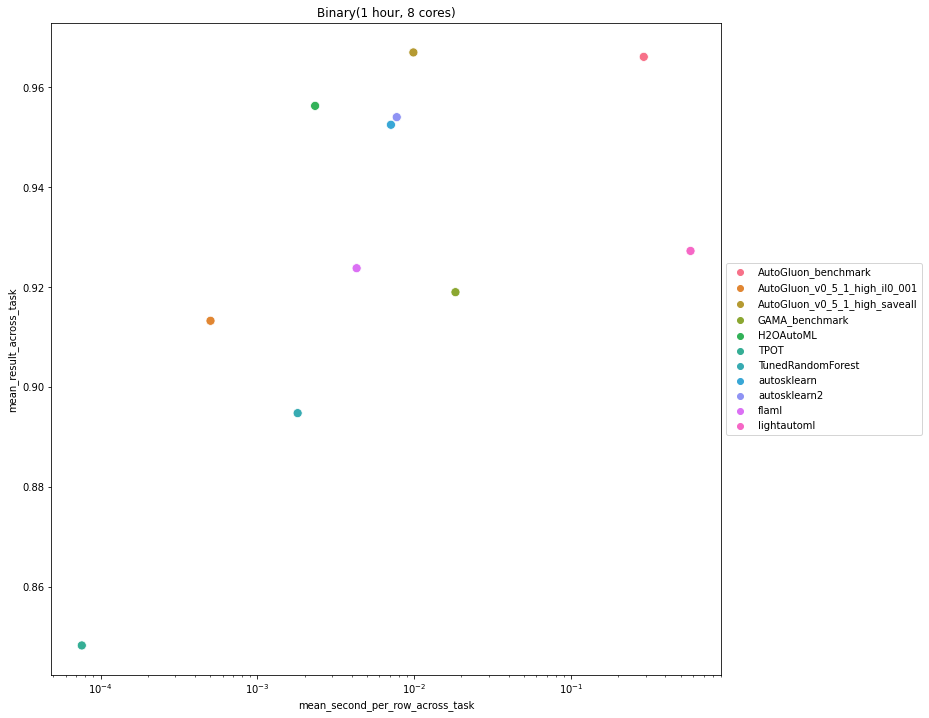

In [7]:
df_to_draw = AMLB_1h8c_binary_per_framework_df.drop(outlier_frameworks).reset_index()

fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xscale('log')
ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax.set_title('Binary(1 hour, 8 cores)')
sns.scatterplot(data=df_to_draw, x='mean_second_per_row_across_task', y='mean_result_across_task', hue='framework', s=82)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

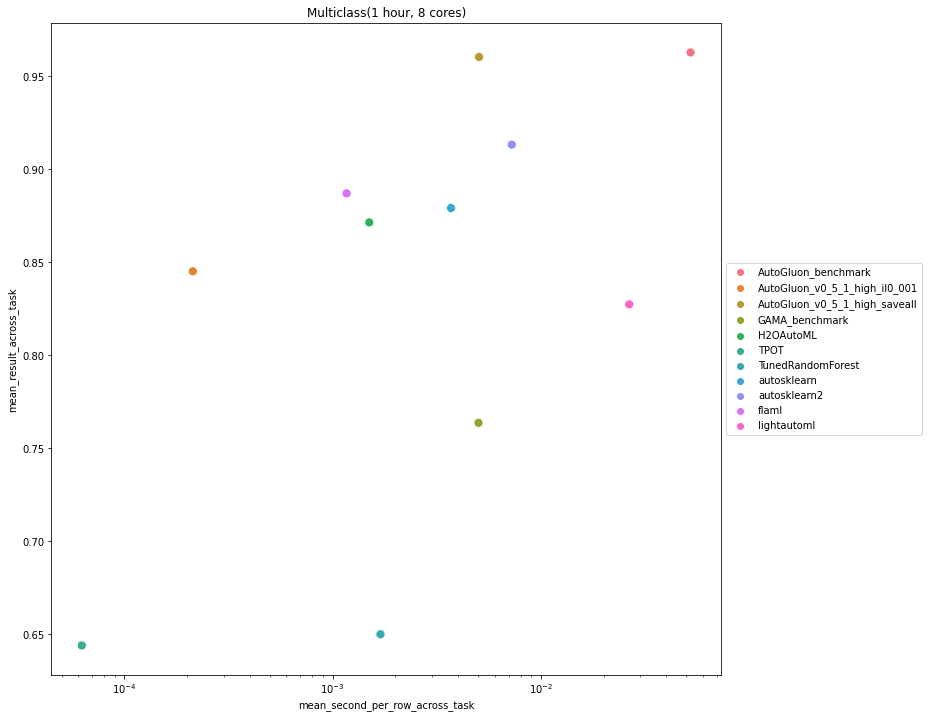

In [8]:

df_to_draw = AMLB_1h8c_multiclass_per_framework_df.drop(outlier_frameworks).reset_index()

fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xscale('log')
ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax.set_title('Multiclass(1 hour, 8 cores)')
sns.scatterplot(data=df_to_draw, x='mean_second_per_row_across_task', y='mean_result_across_task', hue='framework', s=82)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))